In [1]:

import pandas as pd 
import numpy as np
from numpy import *

import time
import os


from datetime import datetime
from datetime import timedelta

from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

#Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse


## Performance metrics
from sklearn.metrics import mean_squared_error

<h2>Initial helpful function definitions</h2>

In [2]:
#Merge data sets
def mergeData(df):
    features =pd.read_csv('features.csv')
    storesdata =pd.read_csv('stores.csv')
    df = pd.merge(df, features, on=['Store','Date','IsHoliday'],
                  how='inner')
    df = pd.merge(df, storesdata, on=['Store'],
                  how='inner')
    return df


def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()
    
def binary(movement):
    #Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change

    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    direction = np.empty(movement.shape[0])
    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(movement.shape[0]):
        if movement[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction

def scatterplots(feature, label):
    x = feature
    y = df['Weekly_Sales']
    plt.scatter(x, y)
    plt.ylabel('sales')
    plt.xlabel(label)
    plt.show()

<h3>Merging datasets</h3>

In [3]:
train = mergeData(pd.read_csv('train.csv'))
test = mergeData(pd.read_csv('test.csv'))
train['Split'] = 'Train'
test['Split'] = 'Test'
test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test


In [4]:
# Get number of training examples
t_len = len(train)

# Join train and test dataset
df = pd.concat([train,test],axis=0)

In [5]:
#Summary od dataframe
df.describe()

,CPI,Dept,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Unemployment,Weekly_Sales
count,498472.000000,536634.000000,536634.000000,265596.000000,197685.000000,242326.000000,237143.000000,266496.000000,536634.000000,536634.000000,536634.000000,498472.000000,421570.000000
mean,172.090481,44.277301,3.408310,7438.004144,3509.274827,1857.913525,3371.556866,4324.021158,136678.550960,22.208621,58.771762,7.791888,15981.258123
std,39.542149,30.527358,0.430861,9411.341379,8992.047197,11616.143274,6872.281734,13549.262124,61007.711799,12.790580,18.678716,1.865076,22711.183519
min,126.064000,1.000000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,34875.000000,1.000000,-7.290000,3.684000,-4988.940000
25%,132.521867,18.000000,3.041000,2114.640000,72.500000,7.220000,336.240000,1570.112500,93638.000000,11.000000,45.250000,6.623000,2079.650000
50%,182.442420,37.000000,3.523000,5126.540000,385.310000,40.760000,1239.040000,2870.910000,140167.000000,22.000000,60.060000,7.795000,7612.030000
75%,213.748126,74.000000,3.744000,9303.850000,2392.390000,174.260000,3397.080000,5012.220000,202505.000000,33.000000,73.230000,8.549000,20205.852500
max,228.976456,99.000000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,219622.000000,45.000000,101.950000,14.313000,693099.360000


In [6]:
#converting temp from farenhit to celcius
df['Temperature'] = (df['Temperature'] - 32) * 5/9

<h2>Exploratory data Analysis</h2>

In [7]:

sns.set(style="white")

#Compute the correlation matrix
corr = df.corr()

#Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

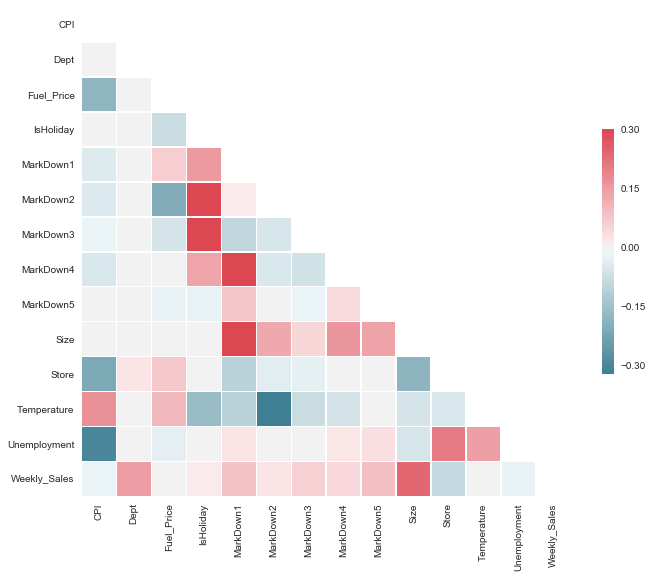

In [8]:
#show correlation matrix
plt.show()

<h3>Important observations</h3>
1. Discounts are correlated. 
2. Higher unemployment means lower Consumer Price Index.
3. Higher department numbers have higher sales. 
4. Also, larger stores generate more sales, discounts generally generate higher sales values and larger unemployment result in a bit fewer sales. Unfortunately, there appears to be little relationship between holidays, temperatures or fuelprices with our weekly sales.

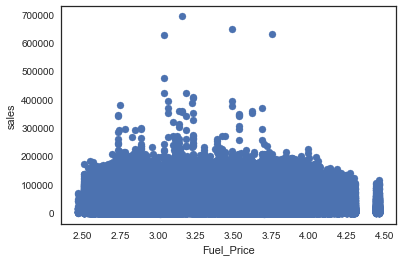

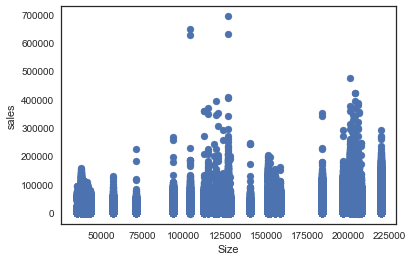

In [9]:
%matplotlib inline

headers = list(df)
labels = headers
scatterplots(df['Fuel_Price'], 'Fuel_Price')
scatterplots(df['Size'], 'Size')

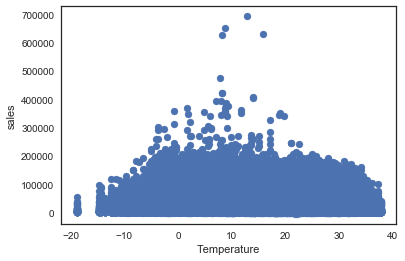

In [10]:
scatterplots(df['Temperature'], 'Temperature')

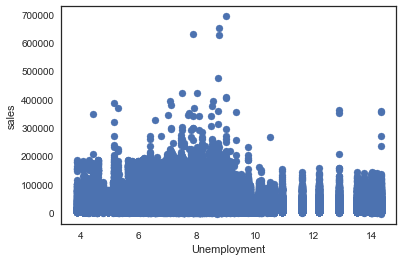

In [11]:
scatterplots(df['Unemployment'], 'Unemployment')

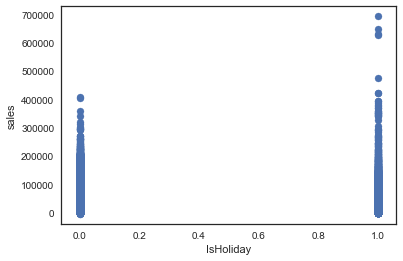

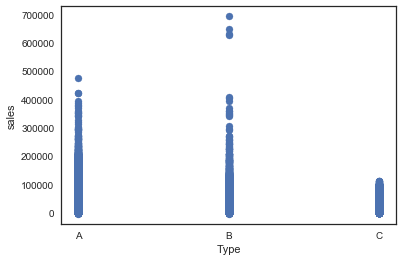

In [12]:
scatterplots(df['IsHoliday'], 'IsHoliday')
scatterplots(df['Type'], 'Type')

<h3>Observations</h3> 
1. Type C stores have fewer sales in general and 
2. Holidays show more sales.

In [13]:
df.loc[df['Weekly_Sales'] >300000]

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Split,Store,Temperature,Type,Unemployment,Weekly_Sales
32594,126.669267,2010-11-26,72,2.752,True,NaN,NaN,NaN,NaN,NaN,205863,Train,4,8.933333,A,7.127,381072.11
36312,129.836400,2011-11-25,72,3.225,True,561.45,137.88,83340.33,44.04,9239.23,205863,Train,4,8.866667,A,5.143,385051.04
36557,129.984548,2011-12-23,7,3.103,False,2461.94,69.05,2938.24,52.00,4396.76,205863,Train,4,2.177778,A,5.143,318422.01
51826,213.267296,2010-11-26,72,2.735,True,NaN,NaN,NaN,NaN,NaN,202505,Train,6,18.772222,A,7.007,342578.65
55545,220.041741,2011-11-25,72,3.236,True,429.03,171.88,83192.81,15.00,986.23,202505,Train,6,17.100000,A,6.551,326866.60
90645,126.669267,2010-11-26,72,3.162,True,NaN,NaN,NaN,NaN,NaN,126512,Train,10,12.961111,B,9.003,693099.36
90886,126.983581,2010-12-24,7,3.236,False,NaN,NaN,NaN,NaN,NaN,126512,Train,10,13.922222,B,9.003,406988.63
90936,126.983581,2010-12-24,72,3.236,False,NaN,NaN,NaN,NaN,NaN,126512,Train,10,13.922222,B,9.003,404245.03
94393,129.836400,2011-11-25,72,3.760,True,174.72,329.00,141630.61,79.00,1009.98,126512,Train,10,15.933333,B,7.874,630999.19
94634,129.984548,2011-12-23,7,3.541,False,300.02,77.73,2432.01,108.37,4078.21,126512,Train,10,9.088889,B,7.874,341308.00


<h3>Observations</h3>
1. End of November has large sales.
2. Black friday has large sales, So dummy variable should be created for this day. 
3. For Christmas, Make a dummy for this day.

In [14]:
df.loc[df['Weekly_Sales'] >240000,"Date"].value_counts()

2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2010-02-05     1
2011-08-26     1
Name: Date, dtype: int64

Except for a handful spurious other dates, it appears that the two days before Christmas and Black Friday will do the job.

<h2>Feature engineering</h2>

In [15]:
df.isnull().sum()

CPI              38162
Date                 0
Dept                 0
Fuel_Price           0
IsHoliday            0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
Size                 0
Split                0
Store                0
Temperature          0
Type                 0
Unemployment     38162
Weekly_Sales    115064
dtype: int64

Basic feature engineering here by creating a feature which indicates whether a certain markdown was active or not.

In [16]:
df = df.assign(md1_present = df.MarkDown1.notnull())
df = df.assign(md2_present = df.MarkDown2.notnull())
df = df.assign(md3_present = df.MarkDown3.notnull())
df = df.assign(md4_present = df.MarkDown4.notnull())
df = df.assign(md5_present = df.MarkDown5.notnull())

<h3>Fill all missing values with zero. For the markdowns this means no promotion was there.</h3> 

In [17]:
df.fillna(0, inplace=True)

<h3>Dummy variables: Categorical Data</h3>


In [18]:
#Make sure we can later recognize what a dummy once belonged to
df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)
df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

In [19]:
# Create dummies
type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])
holiday_dummies = pd.get_dummies(df['IsHoliday'])

Dummy variables: Dates
Create 12 dummy variables; one for each month.

In [20]:
df['DateType'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = [date.month for date in df['DateType']]
df['Month'] = 'Month_' + df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

Next, let's look at 'special dates'. One variable for Christmas, one for black friday. We have to manually look up the dates of black friday if we want to extrapolate our data to other years, but for now we know: 26 - 11 - 2010 and 25 - 11 - 2011.

In [21]:
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, 12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')
df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
df['Pre_christmas'] = 'Pre_christmas_' + df['Pre_christmas'].map(str)
Black_Friday_dummies = pd.get_dummies(df['Black_Friday'] )
Pre_christmas_dummies = pd.get_dummies(df['Pre_christmas'] )


In [22]:

df = pd.concat([df,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies],axis=1)

In [23]:
# Get dataframe with averages per store and department (GROUP BY - MEDIAN sales)
medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median Sales
0,Type_A,Dept_1,Store_1,Month_1,IsHoliday_False,17350.585
1,Type_A,Dept_1,Store_1,Month_10,IsHoliday_False,23388.030
2,Type_A,Dept_1,Store_1,Month_11,IsHoliday_False,19551.115
3,Type_A,Dept_1,Store_1,Month_11,IsHoliday_True,19865.770
4,Type_A,Dept_1,Store_1,Month_12,IsHoliday_False,39109.390


In [24]:
#Merge by type, store, department and month
df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])


In [25]:
#fill NA
df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True)

df['Key'] = df['Type'].map(str)+df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)

In [26]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key
0,211.096358,2010-02-05,Dept_1,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False
1,211.289143,2010-02-19,Dept_1,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False
2,211.319643,2010-02-26,Dept_1,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False
3,212.566881,2011-02-04,Dept_1,2.989,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False
4,213.247885,2011-02-18,Dept_1,3.045,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False


<h2>Lagged Variables</h2>
We will take a lagged variable of our store's previous weeks sales. First add a column with a one week lagged date, sort the data, and then match the lagged sales with the initial dataframe using the department and store number.

Adding a column with a one week lag.

In [27]:
#Attach variable of last weeks time
df['DateLagged'] = df['DateType']- timedelta(days=7)
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged
0,211.096358,2010-02-05,Dept_1,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False,2010-01-29
1,211.289143,2010-02-19,Dept_1,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False,2010-02-12
2,211.319643,2010-02-26,Dept_1,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19
3,212.566881,2011-02-04,Dept_1,2.989,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False,2011-01-28
4,213.247885,2011-02-18,Dept_1,3.045,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False,2011-02-11


Sort dataframe

In [29]:
# Make a sorted dataframe. 
sorted_df = df.sort_values(['Store', 'Dept','DateType'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True)

Loop over its rows and check at each step if the previous week's sales are available. If not, fill with store and department average, which we retrieved before.

In [32]:
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['DateType']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.set_value(index, 'LaggedSales',last['Weekly_Sales'])
        sorted_df.set_value(index, 'LaggedAvailable',1)
    else:
        sorted_df.set_value(index, 'LaggedSales',row['Median Sales']) # Fill with median
        sorted_df.set_value(index, 'LaggedAvailable',0)

    last = row #Remember last row for speed
    #if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        #print(str(int(index*100/row_len))+'% loaded')

In [33]:
sorted_df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-12,24924.50,46039.49,37887.17
2,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
3,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
4,Dept_1,Store_1,2010-03-05,19403.54,21827.90,21280.40


<h3>Merge dataframe</h3>
Merge this new info with our existing dataset.

In [34]:
# Merge by store and department
df = df.merge(sorted_df[['Dept', 'Store','DateType','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','DateType'])

In [35]:
df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
2,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
3,Dept_1,Store_1,2011-02-04,18461.18,21665.76,23510.49
4,Dept_1,Store_1,2011-02-18,37887.17,46845.87,23510.49


In [36]:
flag = 1

if(flag):
    df_backup = df
else:
    df=df_backup
    display(df_backup.head())

<h3>Feature scaling</h3>
For making modelling process easy and robust, we normalize our continous data.

In [37]:
df['Unemployment'] = (df['Unemployment'] - df['Unemployment'].mean())/(df['Unemployment'].std())
df['Temperature'] = (df['Temperature'] - df['Temperature'].mean())/(df['Temperature'].std())
df['Fuel_Price'] = (df['Fuel_Price'] - df['Fuel_Price'].mean())/(df['Fuel_Price'].std())
df['CPI'] = (df['CPI'] - df['CPI'].mean())/(df['CPI'].std())
df['MarkDown1'] = (df['MarkDown1'] - df['MarkDown1'].mean())/(df['MarkDown1'].std())
df['MarkDown2'] = (df['MarkDown2'] - df['MarkDown2'].mean())/(df['MarkDown2'].std())
df['MarkDown3'] = (df['MarkDown3'] - df['MarkDown3'].mean())/(df['MarkDown3'].std())
df['MarkDown4'] = (df['MarkDown4'] - df['MarkDown4'].mean())/(df['MarkDown4'].std())
df['MarkDown5'] = (df['MarkDown5'] - df['MarkDown5'].mean())/(df['MarkDown5'].std())
df['LaggedSales']= (df['LaggedSales'] - df['LaggedSales'].mean())/(df['LaggedSales'].std())

Now, let's change the variable to be forecasted to the difference from the median. Afterward, we can drop the weekly sales

In [38]:
df['Difference'] = df['Median Sales'] - df['Weekly_Sales']

In [39]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,0.877707,2010-02-05,Dept_1,-1.941019,IsHoliday_False,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False,2010-01-29,0.332347,0.0,0.00,-1414.01
1,0.881009,2010-02-19,Dept_1,-2.075633,IsHoliday_False,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False,2010-02-12,1.325278,1.0,-22529.00,-18085.06
2,0.881532,2010-02-26,Dept_1,-1.966549,IsHoliday_False,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19,1.129418,1.0,-18085.06,4106.95
3,0.902894,2011-02-04,Dept_1,-0.973190,IsHoliday_False,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False,2011-01-28,0.109806,1.0,5049.31,1844.73
4,0.914559,2011-02-18,Dept_1,-0.843218,IsHoliday_False,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False,2011-02-11,0.965977,1.0,-14376.68,-23335.38


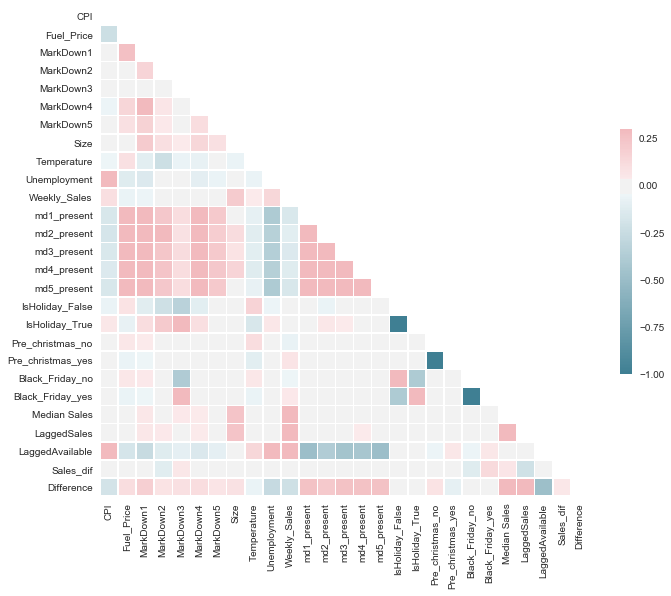

In [40]:
#Correlation matrix

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h3>Select variables to include in model</h3>


In [41]:
selector = [
    #'Month',
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment',
    
    
    
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',

    'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
display(df[selector].describe())
display(df[selector].head())

,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
count,5.366340e+05,5.366340e+05,5.366340e+05,5.366340e+05,5.366340e+05,5.366340e+05,5.366340e+05,536634.000000,5.366340e+05,5.366340e+05,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,5.366340e+05,536634.000000,536634.000000
mean,-1.786115e-13,1.179963e-12,-1.276538e-13,4.771812e-14,-4.577733e-14,-4.858696e-14,4.724414e-15,136678.550960,-2.235463e-13,-1.083398e-12,0.928091,0.071909,0.988851,0.011149,0.988896,0.011104,-2.055088e-14,-195.362035,0.773412
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,61007.711799,1.000000e+00,1.000000e+00,0.258338,0.258338,0.104999,0.104999,0.104791,0.104791,1.000000e+00,6003.550792,0.418624
min,-2.737961e+00,-2.173112e+00,-8.510452e-01,-2.727455e-01,-1.295385e-01,-3.062152e-01,-2.382565e-01,34875.000000,-3.536740e+00,-2.689589e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.809701e-01,-540263.085000,0.000000
25%,-4.920174e-01,-8.525016e-01,-4.847701e-01,-2.262363e-01,-1.067332e-01,-3.062152e-01,-2.193421e-01,93638.000000,-7.239128e-01,-3.358481e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-6.111607e-01,-302.140000,1.000000
50%,-3.325019e-01,2.661879e-01,-4.847701e-01,-2.262363e-01,-1.067332e-01,-3.062152e-01,-2.193421e-01,140167.000000,6.896823e-02,1.223400e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-3.685166e-01,0.000000,1.000000
75%,8.983822e-01,7.791140e-01,1.798095e-01,-2.054580e-01,-1.030260e-01,-1.199173e-01,7.199790e-02,202505.000000,7.740488e-01,4.735060e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.856780e-01,279.820000,1.000000
max,1.183958e+00,2.459469e+00,1.310314e+01,1.806516e+01,1.891040e+01,1.356154e+01,7.858104e+01,219622.000000,2.311628e+00,2.629182e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.984344e+01,579251.325000,1.000000


,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,0.877707,-1.941019,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,151315,-0.881311,0.322635,...,False,1,0,1,0,1,0,0.332347,0.00,0.0
1,0.881009,-2.075633,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,151315,-1.008729,0.322635,...,False,1,0,1,0,1,0,1.325278,-22529.00,1.0
2,0.881532,-1.966549,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,151315,-0.650032,0.322635,...,False,1,0,1,0,1,0,1.129418,-18085.06,1.0
3,0.902894,-0.973190,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,151315,-0.883453,0.187371,...,False,1,0,1,0,1,0,0.109806,5049.31,1.0
4,0.914559,-0.843218,-0.48477,-0.226236,-0.106733,-0.306215,-0.219342,151315,-0.075581,0.187371,...,False,1,0,1,0,1,0,0.965977,-14376.68,1.0


In [42]:
train = df.loc[df['Split']=='Train']
test = df.loc[df['Split']=='Test']
test.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
9,1.102751,2013-02-01,Dept_1,-0.381352,IsHoliday_False,0.738703,0.011752,-0.073020,3.939478,-0.119994,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-01IsHoliday_False,2013-01-25,0.332347,0.0,0.0,23510.49
10,1.103450,2013-02-15,Dept_1,0.154783,IsHoliday_False,9.119972,0.940260,-0.100727,2.368622,0.425218,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-15IsHoliday_False,2013-02-08,0.332347,0.0,0.0,23510.49
11,1.105920,2013-02-22,Dept_1,0.437937,IsHoliday_False,2.163118,0.327459,-0.101365,2.911748,0.374419,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-22IsHoliday_False,2013-02-15,0.332347,0.0,0.0,23510.49
21,1.102751,2013-02-01,Dept_2,-0.381352,IsHoliday_False,0.738703,0.011752,-0.073020,3.939478,-0.119994,...,0,1,0,47080.12,Type_ADept_2Store_12013-02-01IsHoliday_False,2013-01-25,1.371142,0.0,0.0,47080.12
22,1.103450,2013-02-15,Dept_2,0.154783,IsHoliday_False,9.119972,0.940260,-0.100727,2.368622,0.425218,...,0,1,0,47080.12,Type_ADept_2Store_12013-02-15IsHoliday_False,2013-02-08,1.371142,0.0,0.0,47080.12


<h3>Creating validation set to assess model performance</h3>
Usually, model performance can be evaluated on the out-of-sample test set. However, since that data is not available, split our training set to test out of sample performance. 20% of our training set for this development set

In [43]:
# Preparing data (independent and dependent vatiables) for random forest model with validation set as testing set


np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Difference'], test_size=0.2, random_state=42)
print(X_dev.shape)
print(y_dev.shape)

(84314, 24)
(84314,)


In [44]:
#Random forest  (for regression trees) model
regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

#Train on data
regr.fit(X_train, y_train.ravel())

building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

Model evaluation
Look at MAE and accuracy in terms of the number of times it correctly estimated an upward or downward deviation from the median.

In [45]:
y_pred_random = regr.predict(X_dev)

y_dev = y_dev.to_frame()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.4s finished


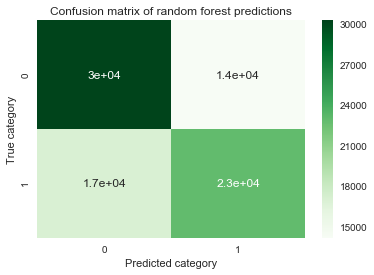

In [46]:
# Transform forest predictions to observe direction of change
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

## show confusion matrix random forest
cnf_matrix = confusion_matrix(direction_true1, direction_predict)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of random forest predictions')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();

In [47]:
y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,Predicted
2,0.881532,2010-02-26,Dept_1,-1.966549,IsHoliday_False,-0.484770,-0.226236,-0.106733,-0.306215,-0.219342,...,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19,1.129418,1.0,-18085.06,4106.95,-4257.36525
7,1.037502,2012-02-17,Dept_1,0.236016,IsHoliday_False,0.815399,1.709712,-0.105486,1.422106,0.128226,...,1,0,23510.49,Type_ADept_1Store_12012-02-17IsHoliday_False,2012-02-10,0.926369,1.0,-13478.00,-30549.61,-8904.63350
14,0.881532,2010-02-26,Dept_2,-1.966549,IsHoliday_False,-0.484770,-0.226236,-0.106733,-0.306215,-0.219342,...,1,0,47080.12,Type_ADept_2Store_12010-02-26IsHoliday_False,2010-02-19,1.408550,1.0,-848.77,2787.25,103.75250
30,1.033155,2012-02-03,Dept_3,-0.112124,IsHoliday_False,4.068508,0.400142,-0.086311,6.353583,0.355781,...,1,0,11135.17,Type_ADept_3Store_12012-02-03IsHoliday_False,2012-01-27,-0.236082,1.0,522.00,-1350.61,-186.77600
39,0.902894,2011-02-04,Dept_4,-0.973190,IsHoliday_False,-0.484770,-0.226236,-0.106733,-0.306215,-0.219342,...,1,0,36479.25,Type_ADept_4Store_12011-02-04IsHoliday_False,2011-01-28,0.746434,1.0,3573.37,608.76,712.52700


In [55]:
df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']
print("Medians: "+str(sum(abs(df_out['Difference']))/df_out.shape[0]))
print("Random Forest: "+str(sum(abs(df_out['Weekly_Sales']-df_out['prediction']))/df_out.shape[0]))

Medians: 1540.2360272315375
Random Forest: 1348.3823585999887


<h2>Build Random Forest Model on full training set</h2>
By merging validation set into training set

In [56]:
#Random forest model
rf_model = RandomForestRegressor(n_estimators=80, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=0, warm_start=False)

#Train on data
rf_model.fit(train[selector], train['Difference'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [57]:
final_y_prediction = rf_model.predict(test[selector])

In [58]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,0,prediction
0,1.102751,2013-02-01,Dept_1,-0.381352,IsHoliday_False,0.738703,0.011752,-0.073020,3.939478,-0.119994,...,0,23510.49,Type_ADept_1Store_12013-02-01IsHoliday_False,2013-01-25,0.332347,0.0,0.0,23510.49,-2504.191062,26014.681062
1,1.103450,2013-02-15,Dept_1,0.154783,IsHoliday_False,9.119972,0.940260,-0.100727,2.368622,0.425218,...,0,23510.49,Type_ADept_1Store_12013-02-15IsHoliday_False,2013-02-08,0.332347,0.0,0.0,23510.49,-3947.680687,27458.170688
2,1.105920,2013-02-22,Dept_1,0.437937,IsHoliday_False,2.163118,0.327459,-0.101365,2.911748,0.374419,...,0,23510.49,Type_ADept_1Store_12013-02-22IsHoliday_False,2013-02-15,0.332347,0.0,0.0,23510.49,-3848.991125,27359.481125
3,1.102751,2013-02-01,Dept_2,-0.381352,IsHoliday_False,0.738703,0.011752,-0.073020,3.939478,-0.119994,...,0,47080.12,Type_ADept_2Store_12013-02-01IsHoliday_False,2013-01-25,1.371142,0.0,0.0,47080.12,-6680.389063,53760.509063
4,1.103450,2013-02-15,Dept_2,0.154783,IsHoliday_False,9.119972,0.940260,-0.100727,2.368622,0.425218,...,0,47080.12,Type_ADept_2Store_12013-02-15IsHoliday_False,2013-02-08,1.371142,0.0,0.0,47080.12,-5760.588188,52840.708188


In [59]:
submission = pd.DataFrame({'id':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Dept']]).map(str)  + '_' +
                           testfile['Date'].map(str),
                          'Weekly_Sales':testfile['prediction']})
submission.head()

,Weekly_Sales,id
0,26014.681062,1_1_2013-02-01
1,27458.170688,1_1_2013-02-15
2,27359.481125,1_1_2013-02-22
3,53760.509063,1_2_2013-02-01
4,52840.708188,1_2_2013-02-15


In [60]:
submission.to_csv("output_rf.csv")